# Article figures

In [1]:
import numpy as np
import scipy.linalg as la
import cvxpy as cvx
import pandas as pd
import networkx as nx

import os
import pickle
import plotly.express as px

import hurwitz
import cvx_inference

import figures

## Introduction

## Methods

### [X] SCS reduction diagram

In [2]:
n = 5
A = np.array(
    [
        [-2.,0,1.,0,1.],
        [0,-2.,0,1.,0],
        [0,0,-2.,0,1.],
        [-1,0,0,-2.,0],
        [0,-1,0,0,-2.]
     ])
gamma = hurwitz.analytic_gamma(A)
E = np.abs(np.sign(A))

u, U = la.eig(gamma)

Alpha_mat = np.full(((n*(n+1))//2,n**2), 0.0)
beta_vec = np.full(((n*(n+1))//2), 0.0)
zero_inds = np.full((n**2), 0)

c1 = 0
for i in range(n):
    for j in range(i,n):

        if i!=j:
            beta_vec[c1] = 0
        else:
            beta_vec[c1] = -1/(2*u[i]).real
        c2 = 0
        for l in range(n):
            for k in range(n):
                if E[l,k] == 0: zero_inds[c2] = 1
                if (i!=j):
                    Alpha_mat[c1, c2] = cvx_inference.alphas(i, j, l, k, U, u).real
                else:
                    Alpha_mat[c1, c2] = cvx_inference.betas(i, l, k, U).real
                c2 += 1
        c1 += 1

vx = cvx.Variable(n**2)
objective = cvx.Minimize(cvx.norm(cvx.multiply(zero_inds,vx), 1))
constraints = [Alpha_mat@vx == beta_vec]
prob = cvx.Problem(objective, constraints)
probdata, chain, inverse_data = prob.get_problem_data(cvx.SCS)
bbb = probdata["b"].reshape((len(probdata["b"]), 1))
fig = px.imshow(
    probdata["A"].toarray(), 
    color_continuous_midpoint=0.0, 
    color_continuous_scale=px.colors.sequential.RdBu
    )
fig.update_traces(dict(
    
))
fig.update_xaxes(dict(
    showticklabels = False
))
fig.update_yaxes(dict(
    showticklabels = False
))
fig.show()

In [3]:
fig.write_image("figs/SCSmatrix.pdf")

### [X] Example images of reconstruction methods on 10x10

## Results

In [300]:
import importlib
importlib.reload(figures)

<module 'figures' from '/Users/ianxul/Library/Mobile Documents/com~apple~CloudDocs/Code/SDENet-Inference/figures.py'>

In [ ]:
import experiments
n = 10
experiments.gen_rand_timeseries(Ns = [n], edge_probs=[n*0.1], mats_num=100)

In [ ]:
import experiments
n = 10
experiments.gen_rand_timeseries(Ns = [n], edge_probs=[n*0.1], mats_num=100, saturating=True)

100%|██████████| 100/100 [11:53<00:00,  7.13s/it]


### [X] Plots of threshold values

In [ ]:
threshs = [[0, 100000, 1000],[1,100001, 500],[5, 100000, 100]]
df_list = []
for thresh in threshs:
    threshfile = "pickles/thresh_{}alpha_{}points_{}reps.pkl".format(thresh[0],thresh[1],thresh[2])
    pkl_obj = pickle.load(open(threshfile,"rb"))
    for c in range(len(pkl_obj)):
        df_list.append([thresh[0]/100, thresh[1], thresh[2], c, pkl_obj[c]])

thresh_df = pd.DataFrame(df_list, columns=["Alpha", "DataPoints", "Reps", "Conditions", "Value"])

In [ ]:
plt = px.line(thresh_df, x = "Conditions", y="Value", color="Alpha")
plt.show()

### [X] Violins of accuracy in different methods

In [ ]:
# import experiments
# n = 10
# experiments.run_E_inference(Ns = [n], edge_probs=[n*0.1], mats_num=100, alphas = [0.01, 0.05, 0.1])
# experiments.run_A_inference(Ns = [n], edge_probs=[n*0.1], mats_num=100, alphas = [0.01, 0.05, 0.1])

100%|██████████| 100/100 [8:59:32<00:00, 323.72s/it]  


In [ ]:
N = 10
step_size = 0.1
edge_prob = N*0.1
pkl_obj = pickle.load(open("pickles/results/inferences/N{}_ss{:.2f}_ep{:.2f}_as.pkl".format(N, step_size, edge_prob), "rb"))

err_df_lst = []

for mat_num in pkl_obj.keys():
    A = pkl_obj[mat_num]["A"]
    for alpha in pkl_obj[mat_num].keys():
        if not type(alpha) is float: continue
        # for method in pkl_obj[mat_num][alpha]["A Inference"].keys():
        for method in ["Full Info + LP", "TE + LP", "No Info + LP"]:
            for rep in range(len(pkl_obj[mat_num][alpha]["A Inference"][method])):
                A_inf = pkl_obj[mat_num][alpha]["A Inference"][method][rep]
                err_df_lst.append([N, mat_num, alpha, rep, method, hurwitz.calc_mat_dist(A,A_inf)])
                
err_df = pd.DataFrame(err_df_lst, columns=["Size", "Mat", "Alpha", "Rep", "Method", "Error"])

In [ ]:
plt = px.violin(err_df[(err_df["Alpha"] == 0.01) & (err_df["Method"].isin(["Full Info + LP", "TE + LP", "No Info + LP"]))], x = "Method", y = "Error", color="Method", box=True, range_y=[0,0.25], points="outliers")
plt.show()

In [ ]:
plt.write_image("figs/SCSmatrix.svg")

### [ ] Violins of accuracy when saturating

In [ ]:
import importlib
importlib.reload(experiments)

<module 'experiments' from '/home/ianxul/Documents/neurolab/CorTe-Inference/experiments.py'>

In [ ]:
import experiments
n = 10
# experiments.gen_rand_timeseries(Ns = [n], edge_probs=[n*0.1], mats_num=100, saturating=True)
# experiments.run_E_inference(Ns = [n], edge_probs=[n*0.1], mats_num=100, alphas = [0.01], saturating=True)
experiments.run_A_inference(Ns = [n], edge_probs=[n*0.1], mats_num=100, alphas = [0.01], saturating = True)

  0%|          | 0/100 [00:00<?, ?it/s]/home/ianxul/Documents/neurolab/CorTe-Inference/corr_inference.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  Alpha_mat[k,r] = alphas(i,j,ll,kk, U, u)
/home/ianxul/Documents/neurolab/CorTe-Inference/corr_inference.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  beta_vec[k] = -betas(i,j, U, u)
/home/ianxul/Documents/neurolab/CorTe-Inference/corr_inference.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  A_sol[i,j] = betas(i,j, U, u) + sum(x_sol*np.array([alphas(i,j,l,k, U, u) for l in range(n) for k in range(l+1,n)]))
100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


In [ ]:
N = 10
step_size = 0.1
edge_prob = N*0.1
pkl_obj = pickle.load(open("pickles/results/inferences/N{}_ss{:.2f}_ep{:.2f}_as_sat.pkl".format(N, step_size, edge_prob), "rb"))

err_df_lst = []

for mat_num in pkl_obj.keys():
    A = pkl_obj[mat_num]["A"]
    for alpha in pkl_obj[mat_num].keys():
        if not type(alpha) is float: continue
        # for method in pkl_obj[mat_num][alpha]["A Inference"].keys():
        for method in ["Full Info + LP", "TE + LP", "No Info + LP"]:
            for rep in range(len(pkl_obj[mat_num][alpha]["A Inference"][method])):
                A_inf = pkl_obj[mat_num][alpha]["A Inference"][method][rep]
                err_df_lst.append([N, mat_num, alpha, rep, method, np.sum(A*A_inf)/(np.sqrt(np.sum(A*A))*(np.sqrt(np.sum(A_inf*A_inf))))])
                
err_df = pd.DataFrame(err_df_lst, columns=["Size", "Mat", "Alpha", "Rep", "Method", "Error"])

In [ ]:
plt = px.violin(err_df[(err_df["Alpha"] == 0.01) & (err_df["Method"].isin(["Full Info + LP", "TE + LP", "No Info + LP"]))], x = "Method", y = "Error", color="Method", box=True, points="outliers")
plt.show()

In [ ]:
XX = 0

In [ ]:
mat_num = XX
XX += 1
alpha = 0.01
hurwitz.make_triple_imshow(pkl_obj[mat_num]["A"], 3*pkl_obj[mat_num][alpha]["A Inference"]["Full Info + LP"][0], pkl_obj[mat_num][alpha]["E Inference"][0], ["A", "TE", "E"])

In [ ]:
## Show also a triple imshow with the correlation matrices produced by the data and the methods just to make sure they're staying within the solution set

### [X] Plot of accuracy/alignment vs. edge probability

In [5]:
pkl_obj = pickle.load(open("pickles/results/inferences/netinf_lin_und_light.pkl","rb"))
methods = ["Full Info + LP", "Full Info + LstSq", "No Info + LP", "No Info + LstSq", "TE + LP", "TE + LstSq", "No Info Tot + LP", "No Info Tot + LstSq"]
df_list = []
for idx in range(len(pkl_obj)):
    A = pkl_obj[idx]["A"]
    for method in methods:
        A_inf = pkl_obj[idx][method]
        df_list.append([idx, pkl_obj[idx]["Params"]["Alpha"], pkl_obj[idx]["Params"]["Edge Prob"], method, hurwitz.calc_mat_dist(A,A_inf)])

ep_df = pd.DataFrame(df_list, columns=["ID", "Alpha", "EdgeProb", "Method", "Error"])

mean_ep_df = ep_df.groupby(['Method','EdgeProb'], group_keys=False).agg({'Error':'median'}).reset_index()
plt = px.line(mean_ep_df, x = "EdgeProb", y="Error", color="Method", title="Median Absolute Error")
plt.show()

In [68]:
import importlib
importlib.reload(figures)

save_fig = False
saturating = True
ignore_diag = True

#methods = ["Full Info + LP", "Full Info + LstSq", "No Info + LP", "No Info + LstSq", "TE + LP", "TE + LstSq", "No Info Tot + LP", "No Info Tot + LstSq"]
methods = ["Full Info + LP", "TE + LP", "No Info + LP", "Precision", "Correlation"]

ep_df = figures.make_ep_df(saturating, methods, ignore_diag)

fig = figures.make_box_plot(ep_df, "EdgeProb", "Correlation", "Method", saturating, ignore_diag, None, size = 900, xlabel="Edge Probability", ylabel="Alignment")

if save_fig: fig.write_image("figs/netinf_edgeprobVScorr_{}{}.svg".format("sat" if saturating else "lin", "_nodiag" if ignore_diag else ""))

fig.show()

### Alignment vs. edge num dom

In [11]:
saturating = False
edm = 30

# methods = ["Full Info + LP", "Full Info + LstSq", "No Info + LP", "No Info + LstSq", "TE + LP", "TE + LstSq", "No Info Tot + LP", "No Info Tot + LstSq"]
methods = ["Full Info + LP", "TE + LP", "No Info + LP", "Precision", "Correlation"]


df_list = []
for mm in [edm]:
    pkl_obj = pickle.load(open("pickles/results/inferences/netinfdom_EM{}_{}_light.pkl".format(mm, "sat" if saturating else "lin"),"rb"))
    for idx in range(len(pkl_obj)):
        A = pkl_obj[idx]["A"]
        if pkl_obj[idx]["Params"]["Epsilon"] in [0.3, 0.5]: continue
        for method in methods:
            A_inf = pkl_obj[idx][method]
            df_list.append([idx, pkl_obj[idx]["Params"]["Alpha"], pkl_obj[idx]["Params"]["Edge Number"], str(pkl_obj[idx]["Params"]["Epsilon"]), method, hurwitz.calc_mat_cos(A,A_inf, ignore_diag = True)])

ep_df = pd.DataFrame(df_list, columns=["ID", "Alpha", "EdgeNum", "Epsilon", "Method", "Alignment"])

mean_ep_df = ep_df.groupby(['Method','Epsilon'], group_keys=False).agg({'Alignment':'median'}).reset_index()
plt = px.line(mean_ep_df, x = "Epsilon", y="Alignment", color="Method", title="Median Absolute Alignment")
plt.show()

In [9]:
import importlib
importlib.reload(figures)

save_fig = True
ignore_diag = True

fig = figures.make_box_plot(ep_df, "Epsilon", "Alignment", "Method", saturating, ignore_diag, None, size = 900, xlabel="Epsilon", ylabel="Alignment (M={})".format(edm))

if save_fig: fig.write_image("figs/netinfdom_EM{}_edgeprobVSalign_{}{}.svg".format(edm,"sat" if saturating else "lin", "_nodiag" if ignore_diag else ""))

fig.show()

In [4]:
compare_label = "TE"
i = np.random.randint(0, len(pkl_obj))
A = pkl_obj[i]["A"]
A_est = pkl_obj[i]["{} + LP".format(compare_label)]
A_est_no_info = pkl_obj[i]["No Info + LP"]

figures.make_triple_imshow(A, A_est, A_est_no_info, ["A #{} (eps:{})".format(i,pkl_obj[i]["Params"]["Epsilon"]), "{} ({:.2f})".format(compare_label, hurwitz.calc_mat_cos(A, A_est, ignore_diag=True)), "No Info ({:.2f})".format(hurwitz.calc_mat_cos(A, A_est_no_info, ignore_diag=True))])

In [5]:
edm = 30

pkl_obj = {}
pkl_obj[False] = pickle.load(open("pickles/results/inferences/netinfdom_EM{}_lin_light.pkl".format(edm),"rb"))
pkl_obj[True] = pickle.load(open("pickles/results/inferences/netinfdom_EM{}_sat_light.pkl".format(edm),"rb"))

# methods = ["Full Info + LP", "Full Info + LstSq", "No Info + LP", "No Info + LstSq", "TE + LP", "TE + LstSq", "No Info Tot + LP", "No Info Tot + LstSq"]
methods = ["Full Info + LP", "TE + LP", "No Info + LP", "Precision", "Correlation"]

df_list = []
for mm in [edm]:
    for method in methods:
        for saturating in [False, True]:
            for idx in range(len(pkl_obj[saturating])):
                A = pkl_obj[saturating][idx]["A"]
                if pkl_obj[saturating][idx]["Params"]["Epsilon"] in [0.3, 0.4, 0.5]: continue
                A_inf = pkl_obj[saturating][idx][method]
                df_list.append([idx, pkl_obj[saturating][idx]["Params"]["Alpha"], pkl_obj[saturating][idx]["Params"]["Edge Number"], str(pkl_obj[saturating][idx]["Params"]["Epsilon"]), method+(" + Sat" if saturating else " + Lin"), hurwitz.calc_mat_cos(A,A_inf, ignore_diag = True)])

ep_df = pd.DataFrame(df_list, columns=["ID", "Alpha", "EdgeNum", "Epsilon", "Method", "Alignment"])

mean_ep_df = ep_df.groupby(['Method','Epsilon'], group_keys=False).agg({'Alignment':'median'}).reset_index()
plt = px.line(mean_ep_df, x = "Epsilon", y="Alignment", color="Method", title="Median Absolute Alignment")
plt.show()

In [6]:
import importlib
importlib.reload(figures)

save_fig = True
ignore_diag = True

colors =["#009ADE", 
         "#76D6FF", 
         "#FF1F5B", 
         "#FF93B0", 
         "#00CD6D", 
         "#79F6BB", 
         "#AF58BA", 
         "#D9AFDE", 
         "#F28522", 
         "#F9C595"] 

fig = figures.make_box_plot(ep_df, "Epsilon", "Alignment", "Method", saturating, ignore_diag, None, size = 900, xlabel="Epsilon", ylabel="Alignment (M={})".format(edm), color_theme=colors)

if save_fig: fig.write_image("figs/netinfdom_EM{}_edgeprobVSalign_full{}.svg".format(edm, "_nodiag" if ignore_diag else ""))

fig.show()

### Significance of median differences

In [16]:
# # Bootstrap significance testing
# def bootstrap_significance_test(df, method1, method2, ep = 0.2, reps = 10000, statistic = np.mean):
    
#     method1_err = df[(df["Method"] == method1) & (df["EdgeProb"] == ep)]["Correlation"]
#     method2_err = df[(df["Method"] == method2) & (df["EdgeProb"] == ep)]["Correlation"]
#     n, m = len(method1_err), len(method2_err)
#     combined = np.concatenate([method1_err, method2_err])
#     diff = statistic(method1_err) - statistic(method2_err)
#     diff_lst = []
#     for _ in range(reps):
#         new_method1_err = np.random.choice(combined, n, replace=True)
#         new_method2_err = np.random.choice(combined, m, replace=True)
#         diff_lst.append(statistic(new_method1_err) - statistic(new_method2_err))
#     p = np.sum(np.abs(diff) < np.abs(diff_lst))/reps
#     return p

# Bootstrap significance testing
def bootstrap_significance_test(df, method1, method2, eps = 0.05, reps = 10000, statistic = np.mean):
    
    method1_err = df[(df["Method"] == method1) & (df["Epsilon"] == str(eps))]["Alignment"]
    method2_err = df[(df["Method"] == method2) & (df["Epsilon"] == str(eps))]["Alignment"]
    n, m = len(method1_err), len(method2_err)
    combined = np.concatenate([method1_err, method2_err])
    diff = statistic(method1_err) - statistic(method2_err)
    diff_lst = []
    for _ in range(reps):
        new_method1_err = np.random.choice(combined, n, replace=True)
        new_method2_err = np.random.choice(combined, m, replace=True)
        diff_lst.append(statistic(new_method1_err) - statistic(new_method2_err))
    p = np.sum(np.abs(diff) < np.abs(diff_lst))/reps
    return p

In [5]:
ep_df

,ID,Alpha,EdgeNum,Epsilon,Method,Alignment
0,0,0.01,20,0.05,Full Info + LP,0.997867
1,0,0.01,20,0.05,TE + LP,0.988821
2,0,0.01,20,0.05,No Info + LP,0.524556
3,0,0.01,20,0.05,Precision,0.487770
4,0,0.01,20,0.05,Correlation,0.513671
...,...,...,...,...,...,...
1995,598,0.01,20,0.4,Full Info + LP,0.997114
1996,598,0.01,20,0.4,TE + LP,0.919924
1997,598,0.01,20,0.4,No Info + LP,0.599796
1998,598,0.01,20,0.4,Precision,0.638236


In [19]:
statistic = np.median
compare_label = "TE"

for eps in [0.05]:
    for method in ["Full Info + LP", "TE + LP", "No Info + LP", "Precision", "Correlation"]:
        p = bootstrap_significance_test(ep_df, method, "{} + LP".format(compare_label), eps, statistic = statistic)
        print("{} = {} (p-value:{})".format(method,compare_label, p))

Full Info + LP = TE (p-value:0.0)
TE + LP = TE (p-value:0.9801)
No Info + LP = TE (p-value:0.0)
Precision = TE (p-value:0.0)
Correlation = TE (p-value:0.0)


### [X] Performance vs. graph size

In [89]:
save_fig = True
saturating = False
ignore_diag = True

#methods = ["Full Info + LP", "Full Info + LstSq", "No Info + LP", "No Info + LstSq", "TE + LP", "TE + LstSq", "No Info Tot + LP", "No Info Tot + LstSq"]
methods = ["Full Info + LP", "TE + LP", "No Info + LP", "Precision", "Correlation"]

ep_df = figures.make_ep_df_N(saturating, methods, ignore_diag)

fig = figures.make_box_plot(ep_df, "N", "Correlation", "Method", saturating, ignore_diag, None, size = 800, xlabel="Network Size", ylabel="Alignment")

if save_fig: fig.write_image("figs/netinf_corrVSsize_{}{}.svg".format("sat" if saturating else "lin", "_nodiag" if ignore_diag else ""))
fig.show()

In [90]:
# Bootstrap significance testing
def bootstrap_significance_test_size(df, method1, method2, size = 10, reps = 10000, statistic = np.mean):
    
    method1_err = df[(df["Method"] == method1) & (df["N"] == size)]["Correlation"]
    method2_err = df[(df["Method"] == method2) & (df["N"] == size)]["Correlation"]
    n, m = len(method1_err), len(method2_err)
    combined = np.concatenate([method1_err, method2_err])
    diff = statistic(method1_err) - statistic(method2_err)
    diff_lst = []
    for _ in range(reps):
        new_method1_err = np.random.choice(combined, n, replace=True)
        new_method2_err = np.random.choice(combined, m, replace=True)
        diff_lst.append(statistic(new_method1_err) - statistic(new_method2_err))
    p = np.sum(np.abs(diff) < np.abs(diff_lst))/reps
    return p

In [91]:
statistic = np.median

for size in [10, 20, 30, 40]:
    print("Network Size: {}".format(size))
    p = bootstrap_significance_test_size(ep_df, "TE + LP", "Full Info + LP", size, statistic = statistic)
    print("Full Info = TE (p-value:{})".format(p))
    p = bootstrap_significance_test_size(ep_df, "TE + LP", "No Info + LP", size, statistic = statistic)
    print("No Info = TE (p-value:{})".format(p))

Network Size: 10
Full Info = TE (p-value:0.0)
No Info = TE (p-value:0.0)
Network Size: 20
Full Info = TE (p-value:0.0)
No Info = TE (p-value:0.0)
Network Size: 30
Full Info = TE (p-value:0.0)
No Info = TE (p-value:0.0)
Network Size: 40
Full Info = TE (p-value:0.0)
No Info = TE (p-value:0.0)


### [X] Figure of one good and one bad example

In [3]:
# Load results
saturating = True
compare_with = "TE + LP"
compare_label = "TE"
# compare_with = "No Info + LP"
# compare_label = "No Info"

pkl_obj = pickle.load(open("pickles/results/inferences/netinfdom_EM20_{}_light.pkl".format("sat" if saturating else "lin"),"rb"))

In [4]:
# Sort results by alignment
pkl_obj.sort(key = lambda pkob : (hurwitz.calc_mat_cos(pkob[compare_with], pkob["A"], ignore_diag=True)))
ii = -1
jj = len(pkl_obj)

In [12]:
# ii = 305 # Med example

while 1:
    ii += 1
    A = pkl_obj[ii]["A"]
    # if nx.is_strongly_connected(nx.from_numpy_matrix(A.T, create_using=nx.DiGraph)): break
    if nx.is_connected(nx.from_numpy_matrix(A.T)): break
A_grn = pkl_obj[ii]["Full Info + LP"]
A_est = pkl_obj[ii][compare_with]
A_est_no_info = pkl_obj[ii]["No Info + LP"]
print("Alignment for mat #{}: {:.2f} with TE and {:.2f} with No Info (ref {:.2f})".format(ii, hurwitz.calc_mat_cos(A, A_est, ignore_diag=True), hurwitz.calc_mat_cos(A, A_est_no_info, ignore_diag=True),hurwitz.calc_mat_cos(A, A_grn, ignore_diag=True)))

fig_bad = figures.make_triple_imshow(A, A_est, A_est_no_info, ["A", compare_label, "No Info"])

Alignment for mat #306: 0.90 with TE and 0.42 with No Info (ref 0.94)


In [74]:
# jj = len(pkl_obj)
while 1:
    jj -= 1
    A = pkl_obj[jj]["A"]
    if nx.is_strongly_connected(nx.from_numpy_matrix(A.T, create_using=nx.DiGraph)): break
    # if nx.is_connected(nx.from_numpy_matrix(A.T)): break
A_grn = pkl_obj[jj]["Full Info + LP"]
A_est = pkl_obj[jj]["TE + LP"]
A_est_no_info = pkl_obj[jj]["No Info + LP"]
print("Alignment for mat #{}: {:.2f} with TE and {:.2f} with No Info (ref {:.2f})".format(jj, hurwitz.calc_mat_cos(A, A_est, ignore_diag=True), hurwitz.calc_mat_cos(A, A_est_no_info, ignore_diag=True),hurwitz.calc_mat_cos(A, A_grn, ignore_diag=True)))

fig_good = figures.make_triple_imshow(A, A_est, A_est_no_info, ["A", compare_label, "No Info"])

Alignment for mat #591: 1.00 with TE and 0.31 with No Info (ref 1.00)


In [38]:
# Save figures
fig_bad.write_image("figs/netinfdom_bad_mat.svg")
fig_good.write_image("figs/netinfdom_good_mat.svg")

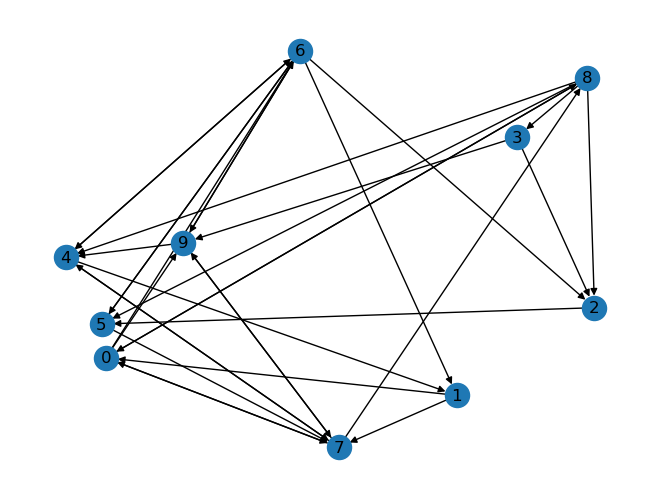

In [54]:
# Plot graph with networkx
import networkx as nx
G = nx.from_numpy_matrix(A-(A*np.eye(A.shape[0])), create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

In [16]:
import importlib
importlib.reload(figures)

save_fig = True
if not saturating:
    # Linear case
    ii_bad = 12 # connected and strongly connected
    # ii_good = 528 # strongly connected
    ii_good = 391 # strongly connected and with worse No Info alignment
    # ii_good = 576 # connected
else:
    # Saturating case
    ii_bad = 16 # connected and strongly connected
    ii_good = 516 # strongly connected
    # ii_good = 565 # connected

fig = figures.make_goodbad_imshow([pkl_obj[ii_good]["A"], pkl_obj[ii_good]["TE + LP"]], [pkl_obj[ii_bad]["A"],pkl_obj[ii_bad]["TE + LP"]], size = 1000, titles = ["True", "Reconstructed (TE Info)"])

# Save figure
if save_fig: 
    fig.write_image("figs/goodbadTE{}.png".format("sat" if saturating else ""), scale = 3)
    fig.write_image("figs/goodbadTE{}.svg".format("sat" if saturating else ""))

fig.show()

In [17]:
fig = figures.make_goodbad_imshow([pkl_obj[ii_good]["A"], pkl_obj[ii_good]["No Info + LP"]], [pkl_obj[ii_bad]["A"],pkl_obj[ii_bad]["No Info + LP"]], size = 1000, titles = ["True", "Reconstructed (No Info)"], goodbad_labs = ["",""])

# Save figure
if save_fig: 
    fig.write_image("figs/goodbadNI{}.png".format("sat" if saturating else ""), scale = 3)
    fig.write_image("figs/goodbadNI{}.svg".format("sat" if saturating else ""))

fig.show()

### [ ] An example with external noise ? 

### [ ] Examples with non-linear (saturating) systems
Imagino que para este caso podría ser una figura que muestre ejemplos particulares de la matriz de conectividad, la reconstrucción, y los valores de alineación 